# import

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from lightai.core import *
from lightai.train import *
import cv2
from torch.utils.data import DataLoader
from src.dataset import *
from src.file_op import *
from src.metric import *
from src.tsfm import *
from src.model import *
from src.loss import *
from src.utils import *
from albumentations import *
import shutil
import torch.multiprocessing as mp
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import WeightedRandomSampler

# train

In [15]:
bs = 96
sz = 512
num_workers = 6
fold = 0

In [16]:
wd = 1e-4
sgd = partial(optim.SGD, lr=0, momentum=0.9, weight_decay=wd)
adam = partial(optim.Adam, weight_decay=wd)

In [17]:
fair_img_tsfm = Compose([
    Flip(p=0.75),
    Transpose(),
    RandomBrightnessContrast(brightness_limit=(-0.3, 0), contrast_limit=(-0.0, 0)),
])
weighted_img_tsfm = Compose([
#     IAAPerspective(p=0.75),
    ShiftScaleRotate(rotate_limit=45, shift_limit=0.1, scale_limit=0, p=0.75,
                     border_mode=cv2.BORDER_CONSTANT),
#     OneOf([
# #         IAAAffine(shear=30, p=0.25, mode='constant'),
#         ShiftScaleRotate(rotate_limit=45, shift_limit=0.1, scale_limit=0.1, p=0.75,
#                          border_mode=cv2.BORDER_CONSTANT),
# #         IAAAffine(shear=30, p=0.15),
# #         ShiftScaleRotate(rotate_limit=45, shift_limit=0.1, scale_limit=0.1, p=0.75),
#         RandomSizedCrop((int(0.8*sz),int(0.9*sz)), sz, sz, p=0.25),
#     ], p=1),
#     OneOf([
#         GridDistortion(),
#         OpticalDistortion(),
#     ], p=0.75),
#     Cutout(16, 16, 16, p=0.75),
])
trn_tsfm = Tsfm(sz, fair_img_tsfm, weighted_img_tsfm)
val_tsfm = Tsfm(sz)

In [18]:
df = pd.read_csv('inputs/full.csv')
trn_ds = Dataset(df, fold=fold, train=True, tsfm=trn_tsfm)
trn_sampler = BatchSampler(WeightedRandomSampler(trn_ds.df['weight'].values, len(trn_ds)), 
                           batch_size=bs, drop_last=True)
# trn_sampler = BatchSampler(RandomSampler(trn_ds), batch_size=bs, drop_last=True)
trn_dl = DataLoader(trn_ds, batch_sampler=trn_sampler, num_workers=num_workers, pin_memory=True)
val_ds = Dataset(df, fold=fold, train=False, tsfm=val_tsfm)
val_sampler = BatchSampler(SequentialSampler(val_ds), batch_size=int(bs), drop_last=False)
val_dl = DataLoader(val_ds, batch_sampler=val_sampler, num_workers=num_workers, pin_memory=True)

In [19]:
name = f'reproduce_fold={fold}'
writer = SummaryWriter(f'log/{sz}/{name}')
model = Model().cuda()
metric = F1(threshold=0.5)
learner = Learner(model=model, trn_dl=trn_dl, val_dl=val_dl, optim_fn=sgd,
                  metrics=[metric], loss_fn=f1_loss,
                  callbacks=[], writer=writer)
to_fp16(learner, 512)
learner.callbacks.append(SaveBestModel(learner, small_better=False, name=name,
                                       model_dir=f'saved/{sz}'))

In [20]:
epoches = 10
max_lr = 5e-2
warmup_batches = 2 * len(trn_dl)
lr1 = np.linspace(max_lr/25, max_lr, num=warmup_batches, endpoint=False)
lr2 = np.linspace(max_lr, max_lr/25, num=epoches*len(trn_dl)-warmup_batches)
lrs = np.concatenate((lr1,lr2))
lr_sched = LrScheduler(learner.optimizer, lrs)

In [21]:
learner.fit(epoches, lr_sched)

best metric: 0.587125


In [34]:
def train_n_folds():
    df = pd.read_csv('inputs/full.csv')
    for fold in range(1, 5):
        trn_ds = Dataset(df, fold=fold, train=True, tsfm=trn_tsfm)
        trn_sampler = BatchSampler(WeightedRandomSampler(trn_ds.df['weight'].values, len(trn_ds)), 
                                   batch_size=bs, drop_last=True)
        trn_dl = DataLoader(trn_ds, batch_sampler=trn_sampler, num_workers=num_workers, pin_memory=True)
        val_ds = Dataset(df, fold=fold, train=False, tsfm=val_tsfm)
        val_sampler = BatchSampler(SequentialSampler(val_ds), batch_size=bs, drop_last=False)
        val_dl = DataLoader(val_ds, batch_sampler=val_sampler, num_workers=num_workers, pin_memory=True)
        
        name = f'reproduce_fold={fold}'
        writer=SummaryWriter(f'log/{sz}/{name}')
        model = Model(base=torchvision.models.resnet18).cuda()
        metric = F1(threshold=0.5)
        learner = Learner(model=model, trn_dl=trn_dl, val_dl=val_dl, optim_fn=sgd,
                          metrics=[metric], loss_fn=f1_loss,
                          callbacks=[], writer=writer)
        to_fp16(learner, 512)
        learner.callbacks.append(SaveBestModel(learner, small_better=False, name=name,
                                               model_dir=f'saved/{sz}'))
        
        epoches = 10
        max_lr = 5e-2
        warmup_batches = 2 * len(trn_dl)
        lr1 = np.linspace(max_lr/25, max_lr, num=warmup_batches, endpoint=False)
        lr2 = np.linspace(max_lr, max_lr/25, num=epoches*len(trn_dl)-warmup_batches)
        lrs = np.concatenate((lr1,lr2))
        lr_sched = LrScheduler(learner.optimizer, lrs)
        learner.fit(epoches, lr_sched)

In [35]:
train_n_folds()

best metric: 0.594743


best metric: 0.588599


best metric: 0.603783


best metric: 0.597711


In [ ]:
0.418061,0.391008,0.391394,0.394794,0.397580

# inspect

In [10]:
score = score_wrt_threshold(model, val_dl)

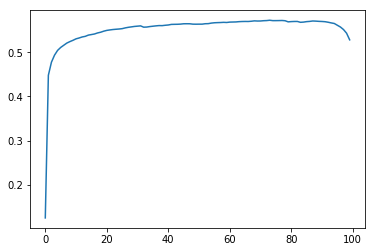

In [11]:
plt.plot(score)

In [69]:
scores = score_wrt_threshold_per_cls(model, val_dl)

In [70]:
scores = scores.cpu().numpy()

In [71]:
scores = scores.transpose()

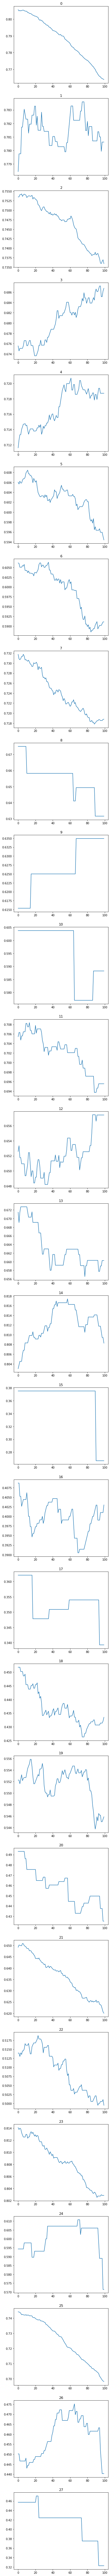

In [72]:
_, axes = plt.subplots(28,1,figsize=(6,6*28))
for c, score,ax in zip(range(28), scores,axes):
    ax.plot(score)
    ax.set_title(str(c))

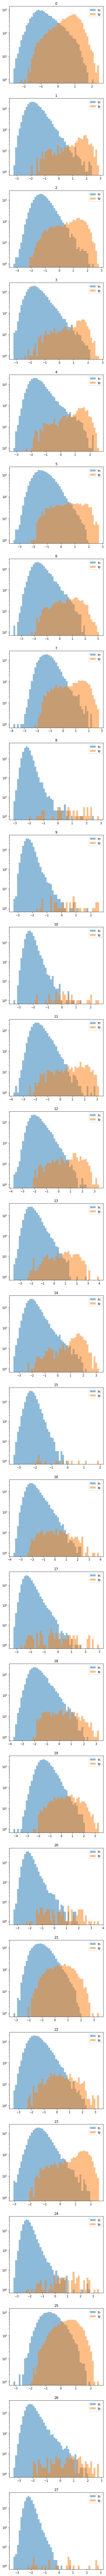

In [18]:
c_tp_vs_tn(model, val_dl)

(array([5913., 1520.,  953.,  776.,  626.,  580.,  473.,  438.,  408.,
         405.,  401.,  384.,  349.,  332.,  330.,  371.,  355.,  383.,
         366.,  401.,  421.,  461.,  519.,  531.,  621.,  704.,  985.,
        1313., 2503., 9161.]),
 array([453053.,  22207.,  12494.,   8253.,   6293.,   5058.,   4202.,
          3630.,   3146.,   2935.,   2542.,   2406.,   2221.,   2071.,
          1937.,   1922.,   1644.,   1628.,   1640.,   1494.,   1411.,
          1393.,   1356.,   1434.,   1271.,   1379.,   1542.,   1651.,
          2209.,   4403.]))

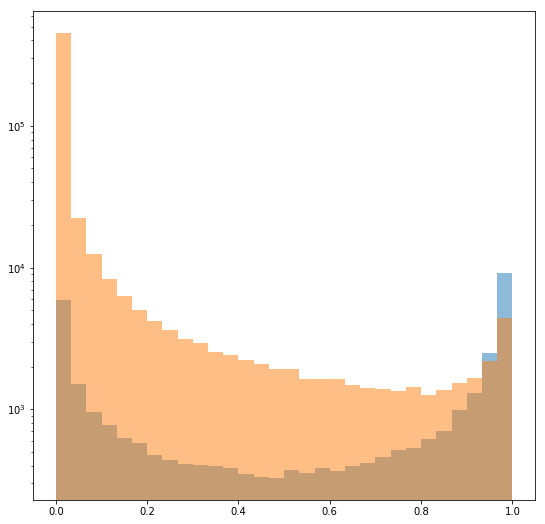

In [15]:
tp_vs_tn(model, val_dl)

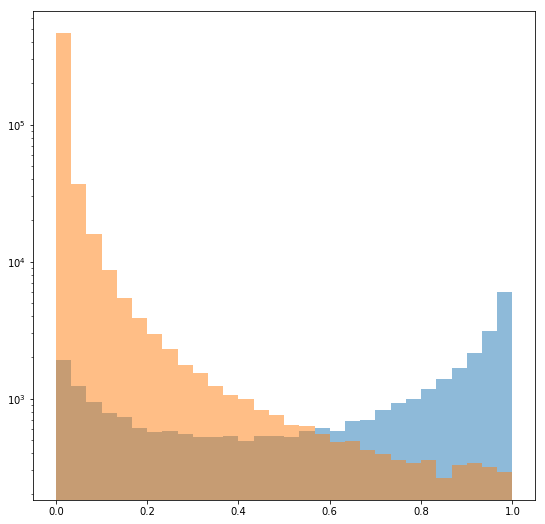

In [190]:
tp_vs_tn(model, val_dl)

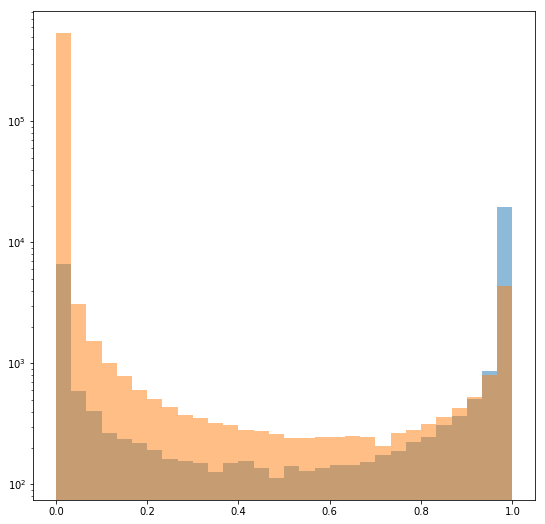

In [187]:
tp_vs_tn(model, val_dl)

In [65]:
submission = pd.read_csv('inputs/sample_submission.csv')
sz = 512
test_ds = Dataset(submission, fold=None, train=None, tsfm=TestTsfm(sz, tta=False))
test_sampler = BatchSampler(SequentialSampler(test_ds), batch_size=bs, drop_last=False)
test_dl = DataLoader(test_ds, batch_sampler=test_sampler, num_workers=3, pin_memory=True)

# thresholds

In [191]:
scores = val_score_wrt_threshold(model, val_dl)

In [192]:
thresholds = scores.argmax(dim=0).half()/100

In [193]:
thresholds

tensor([0.3601, 0.6899, 0.1000, 0.9502, 0.2500, 0.7100, 0.4502, 0.5000, 0.8901,
        0.4602, 0.8501, 0.5601, 0.6401, 0.8901, 0.5801, 0.5601, 0.9502, 0.8003,
        0.8403, 0.4302, 0.2900, 0.6602, 0.8701, 0.3601, 0.9302, 0.2600, 0.9404,
        0.6802], device='cuda:0', dtype=torch.float16)

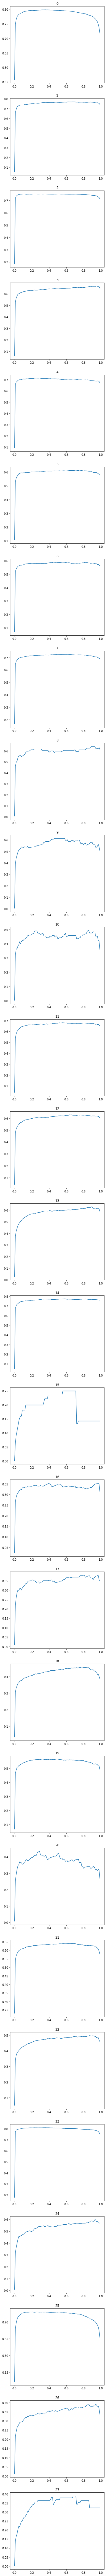

In [194]:
img_sz = 6
_, axes = plt.subplots(28, 1, figsize=(img_sz*1,img_sz*28))
for i, ax in enumerate(axes):
    ax.plot(np.linspace(0,1,endpoint=False,num=100), scores[:,i].cpu().numpy())
    ax.set_title(i) 

# lr_Find

In [20]:
lr_finder = LRFinder(model,learner.optimizer,1e-4,5,300)

In [21]:
learner.fit(1, lr_finder)

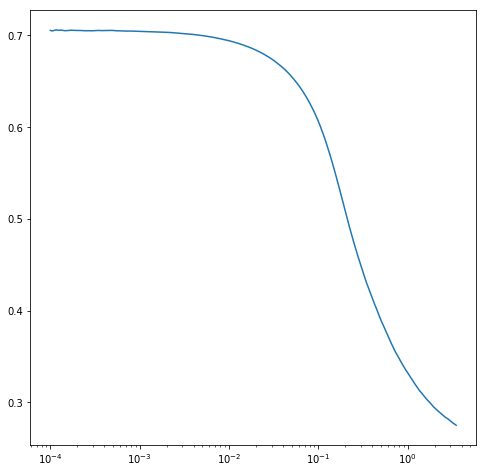

In [22]:
plt.figure(figsize=(8,8))
lr_finder.plot(0,10)

# submit

In [36]:
submission = pd.read_csv('inputs/sample_submission.csv')

In [37]:
sz = 512
test_ds = Dataset(submission, fold=None, train=None, tsfm=TestTsfm(sz))
test_sampler = BatchSampler(SequentialSampler(test_ds), batch_size=8, drop_last=False)
test_dl = DataLoader(test_ds, batch_sampler=test_sampler, num_workers=6, pin_memory=True)

In [38]:
%%time
# model = learner.model
models = []
for fold in range(5):
    model = Model(base=torchvision.models.resnet18).cuda()
    model.half()
    bn_to_float(model)
    model.load_state_dict(torch.load(f'saved/512/reproduce_fold={fold}')['model'])
    models.append(model)
# model.load_state_dict(torch.load('saved/512/pretrain_with_bce_fold=0')['model'])
# models.append(model)
with torch.no_grad():
    for idx, imgs in progress_bar(zip(test_sampler, test_dl), total=len(test_dl)):
        predicts = []
        for img in imgs:
            img = img.cuda()
            for model in models:
                model.eval()
                predict = model(img)
                predict = predict.sigmoid()
                predicts.append(predict)
        weight = [1.0/8/len(models)]*(8*len(models))
#         weight = [1.0]
        weight = T(np.array(weight)).half().reshape(-1, 1, 1)
        predict = (torch.stack(predicts)*weight).sum(dim=0)
        predict[torch.arange(predict.shape[0]), predict.argmax(dim=1)] = 1.0
        predict = predict > 0.3
        predict = predict.cpu().numpy()
        for i, row in zip(idx, predict):
            res = ' '.join([str(p.squeeze()) for p in row.nonzero()[0]])
            submission.loc[i, 'Predicted'] = res

CPU times: user 9min 55s, sys: 1min 54s, total: 11min 49s
Wall time: 10min 18s


In [40]:
submission.to_csv('submission.csv', index=False)

# visualize

In [173]:
ds = Dataset(df, fold=0, train=True, tsfm=Tsfm(512))

In [174]:
def tsfm_contrast(ds, aug):
    row = 2
    column = 2
    img_sz = 8
    _, axes = plt.subplots(row,column,figsize=(img_sz*column,img_sz*row))
    for row in axes:
        i = np.random.randint(0, len(ds))
        img = ds[i][0]
        row[0].imshow(img[:,:,:3])
        auged_img = aug(image=img)['image']
        row[1].imshow(auged_img[:,:,:3])

In [175]:
aug = Compose([
    IAAPerspective(p=0.75),
#         ShiftScaleRotate(rotate_limit=0, shift_limit=.1, scale_limit=0, border_mode=cv2.BORDER_CONSTANT),
#         ShiftScaleRotate(rotate_limit=45, shift_limit=.0, scale_limit=0, border_mode=cv2.BORDER_CONSTANT),
#         ShiftScaleRotate(rotate_limit=0, shift_limit=.0, scale_limit=0.1, border_mode=cv2.BORDER_CONSTANT),
    ShiftScaleRotate(rotate_limit=45, shift_limit=.1, scale_limit=0.1,
                     border_mode=cv2.BORDER_CONSTANT, p=0.75),
], p=1)

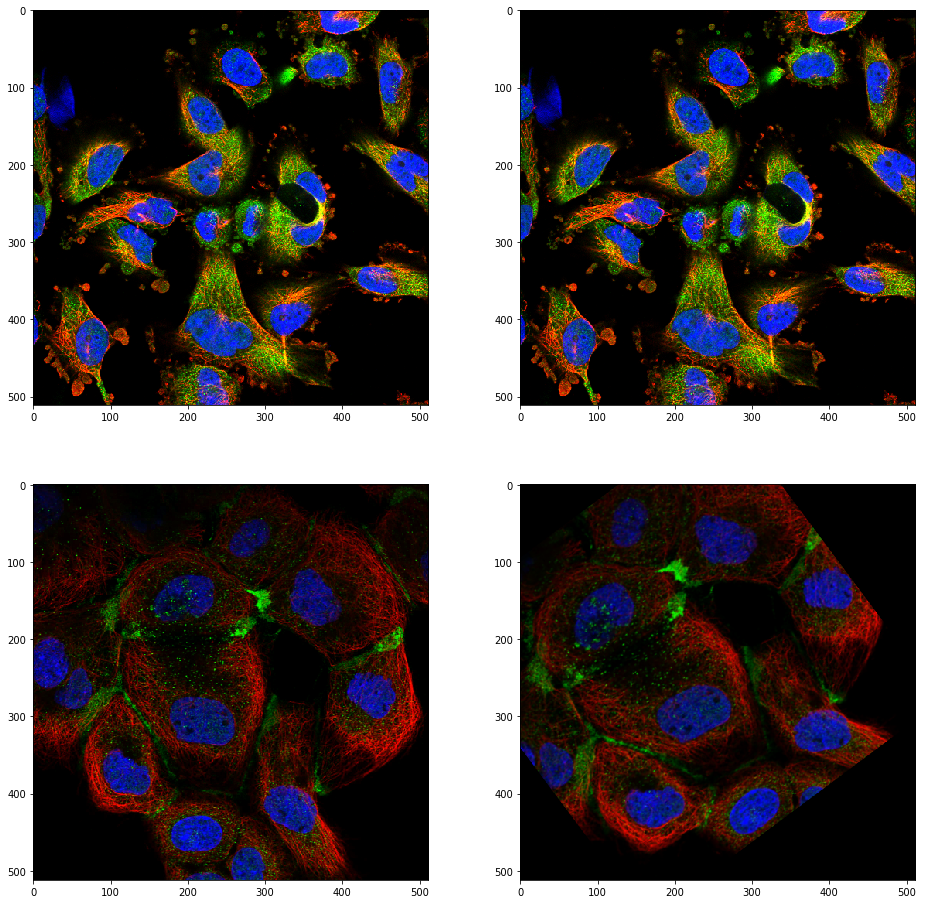

In [178]:
tsfm_contrast(ds, aug)

In [128]:
img = cv2.imread('temp.jpg')

In [129]:
aug = IAAPerspective(p=1)

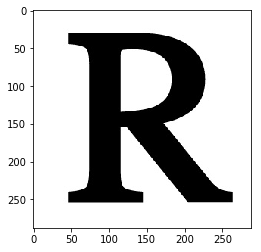

In [131]:
plt.imshow(img)

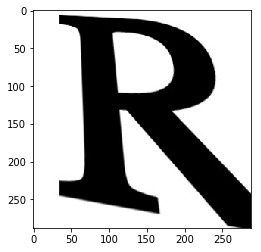

In [142]:
plt.imshow(aug(image=img)['image'])